# Importacion de librerias


In [1]:
# Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/drive')

params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

Mounted at /content/drive


# Lectura de datos

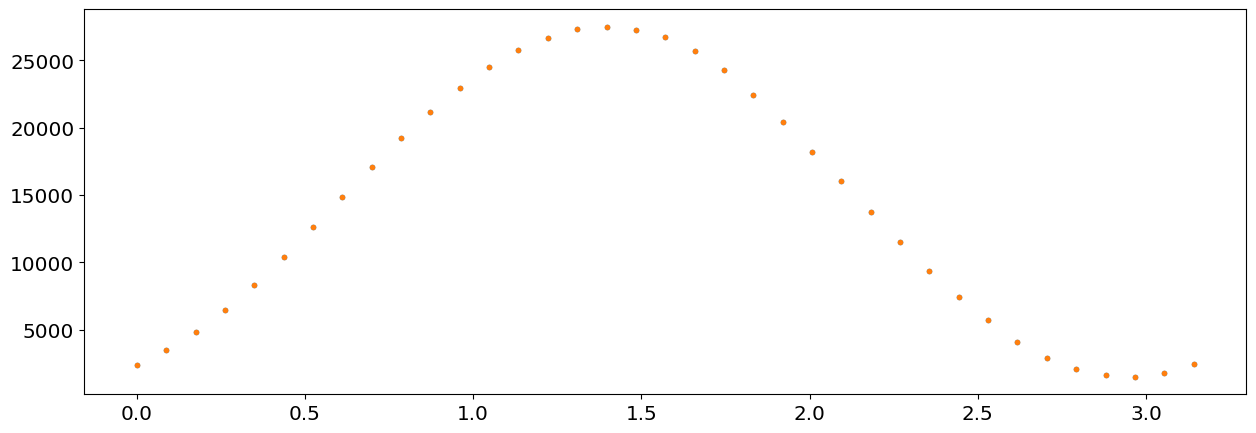

el minimo de intensidad luminosa es de: 1521.701583 lux
el maximo de intensidad luminosa es de: 27480.013438 lux


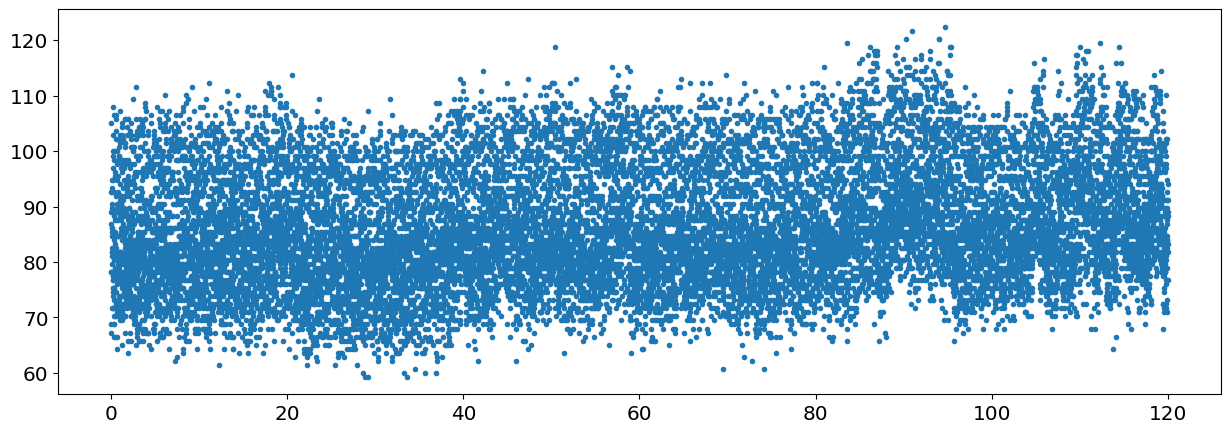

In [2]:
angulo, lux, error_lux = np.loadtxt('/content/drive/MyDrive/Optica/Clase 1/AngulosMalus.csv', skiprows=1, delimiter=',', unpack=True)
angulo = angulo*np.pi/180
plt.errorbar(angulo, lux, yerr = error_lux, fmt=".")
tiempo, lux2 = np.loadtxt('/content/drive/MyDrive/Optica/Clase 1/Ruido del tubo.csv', skiprows=4, delimiter='\t', unpack=True)
plt.errorbar(angulo, lux, yerr = error_lux, fmt=".")
plt.show()
plt.errorbar(tiempo, lux2, yerr = 0, fmt=".")
print("el minimo de intensidad luminosa es de: " + str(np.min(lux)) + " lux")
print("el maximo de intensidad luminosa es de: " + str(np.max(lux)) + " lux")

# Declaracion de funciones

## Ajuste eliptico

In [6]:
def R2(y_data, y_model):
    ss_res = np.sum((y_data - y_model)**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    return 1 - (ss_res / ss_tot)
# Pruebo a ajustar ocn curvefit
def Elipse(x, a,b,q):
  f = (a*np.cos(x))**2 + (b*np.sin(x))**2 + a*b*np.sin(2*x)*np.cos(q)
  return f

# Definimos una funcion que realiza el grafico.
def AjusteEliptico(x, y, error_y, param_ini, ejex, ejey, y_residuos, titulo, formula):
  #Ajustamos
  popt,pcov = curve_fit(Elipse,x,y, sigma = error_y, p0 = param_ini, maxfev = 5000)
  a, b, c = popt
  Sa, Sb, Sc = np.sqrt(np.diag(pcov))
  # para que se vea mejor el ajuste en el gráfico
  x1 = np.linspace(min(x),max(x),10000)
  y_ajustado = Elipse(x1,a, b, c)

  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 9))
  # Grafico de arriba (el ajuste y las mediciones)
  ax[0] = plt.subplot(2,1,1)
  ax[0].plot(x1,y_ajustado,label=formula, color = "blue")
  ax[0].errorbar(x, y, yerr = error_y, fmt='.', label='Mediciones', alpha = 1.0, color= "darkgreen")

  ax[0].grid(which='major', color='black', linestyle='-',alpha=0.6)
  ax[0].grid(which='minor', color='black', linestyle='-',alpha=0.3)
  ax[0].minorticks_on()
  ax[0].set_ylabel(ejey)
  ax[0].set_xlim(-0.1,3.5)
  ax[0].set_title(label=titulo, color = "black", fontweight =  "bold")
  ax[0].legend(facecolor = "bisque",loc="upper right")


  # hago la resta del valor de la funcion vs el del ajuste, asi obtenemos los residuos
  residuos = y - Elipse(x,a,b,c)
  ax[1].errorbar(x, residuos, xerr = 0, yerr = error_y, fmt=".", label="Residuos", color="red")
  ax[1].grid(which='major', color='black', linestyle='-',alpha=0.6)
  ax[1].grid(which='minor', color='black', linestyle='-',alpha=0.3)
  ax[1].minorticks_on()
  ax[1].set_xlabel(str(ejex))
  ax[1].set_ylabel(y_residuos)
  ax[1].set_xlim(-0.1,3.5)
  ax[1].legend(facecolor= "aquamarine")

  # Calculamos parametros estadisticos
  res_sq = (residuos)**2
  # variabilidad intrínseca
  ss_tot = np.sum((y - np.mean(y)) ** 2)
  # R²
  r2 = R2(Elipse(x,a, b, c), y)
  # χ²
  chi_cuadrado = np.sum(((residuos)/error_y)**2)
  grados_libertad = len(x) - len(popt) # grados de libertad
  ch2_reducido = chi_cuadrado/grados_libertad
  # pearson
  from scipy.stats import pearsonr
  rp = pearsonr(x, y)[0]

  ax[0].text(x = 2.7, y = 12500, s = "Parámetros:" +
           '\nχ² = ' + f'{float(f"{ch2_reducido:.3g}"):g}' + #'  R² = ' + f'{float(f"{r2:.4g}"):g}' +
           '\n$a = $(' + f'{float(f"{a:.5g}"):g}' + " ± " f'{float(f"{Sa:.2g}"):g})' + r' $[lux]$'+
            '\n$b = $(' + f'{float(f"{b:.5g}"):g}' + " ± " f'{float(f"{Sb:.2g}"):g})' + r' $[lux]$' +
            '\n$δ = $(' + '0.9050' + " ± " f'{float(f"{Sc:.2g}"):g})' + r' $[rad]$',
            bbox = dict(boxstyle="round", color = "lavender", alpha = 0.7), fontsize='large', color='black')
  return a, Sa, b, Sb, c, Sc

## Propagacion de error

In [7]:
import sympy as sym
import math
import numpy as np

def Δ(derivada1, derivada2, derivada3, derivada4, derivada5, Δ1, Δ2, Δ3, Δ4, Δ5,):
   return np.sqrt((derivada1**2)*(Δ1**2)+(derivada2**2)*(Δ2**2)+(derivada3**2)*(Δ3**2)+(derivada4**2)*(Δ4**2)+(derivada5**2)*(Δ5**2))

def CalcularError(x1, x2, x3, x4, x5, error_x1, error_x2, error_x3, error_x4, error_x5, funcion):
  a, b, c, d, e = sym.symbols('a b c d e')

  # Derivo respecto a las varaibles x e y
  def dfda(a,b,c,d,e):
      return sym.diff(funcion(a,b,c,d,e),a)
  def dfdb(a,b,c,d,e):
      return sym.diff(funcion(a,b,c,d,e),b)
  def dfdc(a,b,c,d,e):
      return sym.diff(funcion(a,b,c,d,e),c)
  def dfdd(a,b,c,d,e):
      return sym.diff(funcion(a,b,c,d,e),d)
  def dfde(a,b,c,d,e):
      return sym.diff(funcion(a,b,c,d,e),e)


  # imprimo la formula derivada
  print("df/da: " + str(dfda(a,b,c,d,e)))
  print("df/db: " + str(dfdb(a,b,c,d,e)))
  print("df/dc: " + str(dfdc(a,b,c,d,e)))
  print("df/dd: " + str(dfdd(a,b,c,d,e)))
  print("df/de: " + str(dfde(a,b,c,d,e)))


  # Convierto de scipy a numpy para poder evaluar la funcion
  dfda_np = sym.lambdify((a,b,c,d,e),dfda(a,b,c,d,e),"numpy")
  dfdb_np = sym.lambdify((a,b,c,d,e),dfdb(a,b,c,d,e),"numpy")
  dfdc_np = sym.lambdify((a,b,c,d,e),dfdc(a,b,c,d,e),"numpy")
  dfdd_np = sym.lambdify((a,b,c,d,e),dfdd(a,b,c,d,e),"numpy")
  dfde_np = sym.lambdify((a,b,c,d,e),dfde(a,b,c,d,e),"numpy")
  #funcion = sym.lambdify((x,y),funcion(x,y),"numpy")

  # Evaluo las derivadas parciales
  derivada_a = dfda_np(x1,x2,x3,x4,x5)
  derivada_b = dfdb_np(x1,x2,x3,x4,x5)
  derivada_c = dfdc_np(x1,x2,x3,x4,x5)
  derivada_d = dfdd_np(x1,x2,x3,x4,x5)
  derivada_e = dfde_np(x1,x2,x3,x4,x5)

  Valor_mas_representativo = funcion(x1,x2,x3,x4,x5)
  error_absoluto = Δ(derivada_a, derivada_b, derivada_c,derivada_d, derivada_e, error_x1, error_x2, error_x3,error_x4,error_x5)
  return Valor_mas_representativo, error_absoluto

# Ejecucion de codigo


[10.334733 11.778414 10.721314 12.501603 12.429164 13.277256 12.937838
 14.027391 13.633948 13.819974 14.888333 30.301719 15.51637  13.113503
 12.09108  12.879387 11.287421 12.015738 11.936513 12.776233 11.436661
 13.399271 11.75549  13.232666 14.881903 13.281508 13.214083 12.547848
 11.658943 11.542735 10.849616 10.633536 10.525633 10.20013   9.989144
 11.21017  11.199582]
48.70975145157645
162.63190930336123
0.9049743367363149


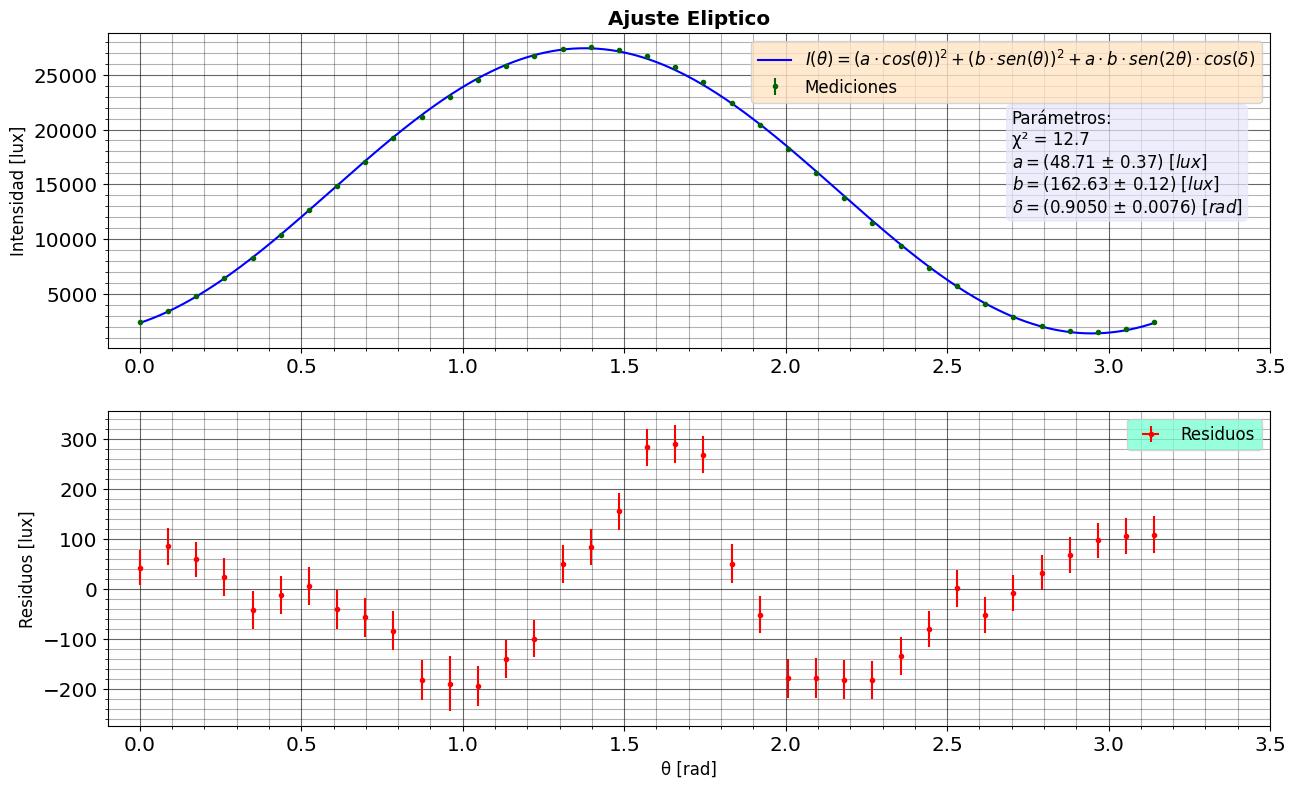

In [8]:
# Paso como datos, que el
a2 = lux[0]
b2 = lux[18]
param_ini2 = np.array([np.sqrt(a2),np.sqrt(b2),1])
print(error_lux)
a, Sa, b, Sb, e, Se = AjusteEliptico(angulo, lux, error_lux + 25, param_ini2,  "θ [rad]", "Intensidad [lux]", "Residuos [lux]", "Ajuste Eliptico", r'$I(θ) = (a\cdot cos(θ))^2 +(b\cdot sen(θ))^2 + a\cdot b\cdot sen(2θ)\cdot cos(δ)  $')
print(a)
print(b)
print(e)

48.659075283163155 162.59997614411506 0.9050381659531094 0.38792820198328626 0.12031280389765801 0.007986659968792779
df/da: (-4*a**2*b*cos(c)/(a**2 + b**2)**2 + 2*b*cos(c)/(a**2 + b**2))/(2*(4*a**2*b**2*cos(c)**2/(a**2 + b**2)**2 + 1))
df/db: (-4*a*b**2*cos(c)/(a**2 + b**2)**2 + 2*a*cos(c)/(a**2 + b**2))/(2*(4*a**2*b**2*cos(c)**2/(a**2 + b**2)**2 + 1))
df/dc: -a*b*sin(c)/((a**2 + b**2)*(4*a**2*b**2*cos(c)**2/(a**2 + b**2)**2 + 1))
df/dd: 0
df/de: 0
0.163550887588339 0.001851863297431755
3.3416166500882385


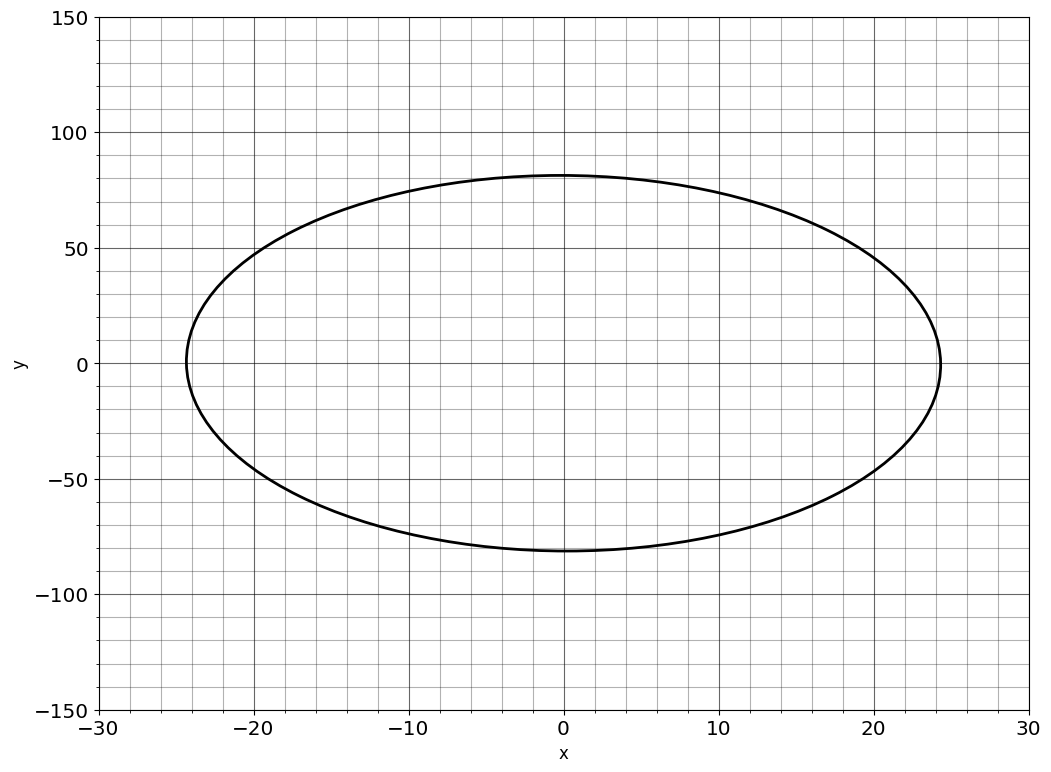

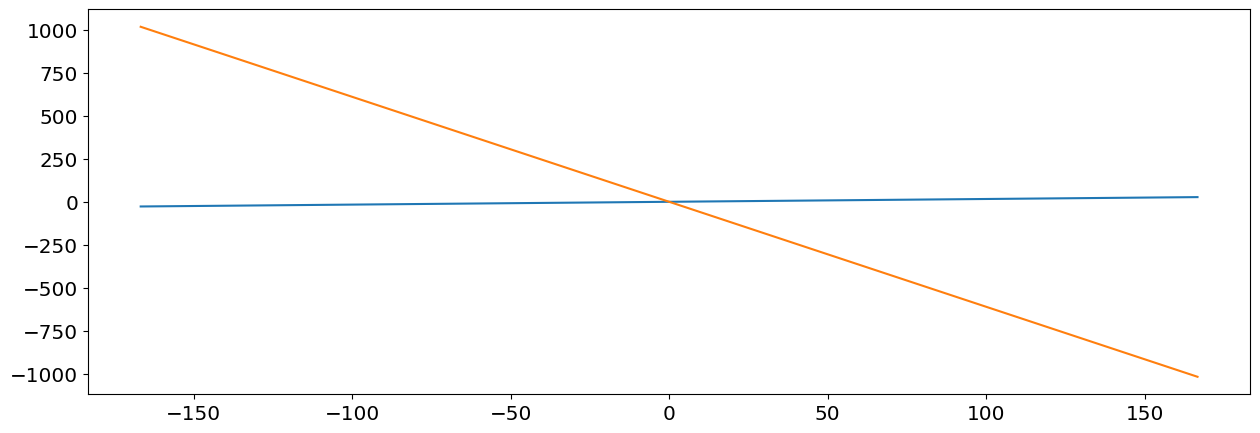

In [ ]:
# Obtengo el angulo de inclinacion de la elipse
# Observacion, uso sympy porque el derivador no anda ni con math ni con numpy
import sympy as sym
print(a,b,e,Sa,Sb,Se)
def AnguloPsi(a,b,e,x1,x2):
  z = sym.atan((2*a*b*sym.cos(e))/(a**2+b**2))/2
  return z
Ψ, ΔΨ = CalcularError(a,b,e,0,0,Sa, Sb,Se,0,0, AnguloPsi)
print(Ψ, ΔΨ)
print(b/a)
from matplotlib import patches
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
e1 = patches.Ellipse((0, 0), a, b,
                     angle=Ψ, linewidth=2, fill=False, zorder=2)
ax.add_patch(e1)
Rango_x = 30
ax.set_xlim([-Rango_x, Rango_x])
ax.set_ylim([-150, 150])
ax.grid(which='major', color='black', linestyle='-',alpha=0.6)
ax.grid(which='minor', color='black', linestyle='-',alpha=0.3)
ax.minorticks_on()
ax.set_ylabel("y")
ax.set_xlabel("x")
x1 = np.array([])
for i in range(-5000,5000):
  x1 = np.append(x1,i/Rango_x)
y = Ψ*x1
y2 = (-1/Ψ)*x1
plt.show()
plt.plot(x1,y)
plt.plot(x1,y2)
